In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

import scanning
import scanning.visualization as vis

# Simulation

## Hitmaps

Create a `Simulation` object by passing in a `TelescopePattern` object and its associated `Module` object. Specify parameters to filter out samples and/or detectors. This will allow you to generate a 2D histogram of the hitmap (that can be returned and plotted). 

TO ADD: Bin line plots

In [2]:
# create an Instrument with a Module
prime_cam = scanning.PrimeCam()
prime_cam.add_module('Mod280', 'i1')

# create a SkyPattern 
daisy = scanning.Daisy(velocity=1/3, start_acc=0.2, R0=0.47, Rt=800*u.arcsec, Ra=600*u.arcsec, T=186, sample_interval=1/400)

# set an observation for TelescopePattern (needed to get field rotation)
daisy_T = scanning.TelescopePattern(daisy, prime_cam, data_loc='i1', start_ra=40, start_dec=-60, start_hrang=0)

Generating histograms for kept hits...
...0/40035 completed...
total number of hits 207541440 == 207541440.0
Generating histograms for removed hits...
...0/34365 completed...
total number of hits 178148160 == 178148160.0


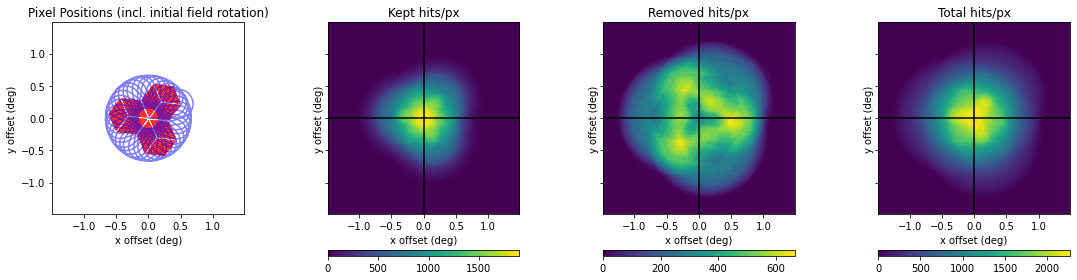

In [3]:
sim1 = scanning.Simulation(
    daisy_T, module='Mod280', # pass the identifier of the module
    pixel_size=10*u.arcsec,             # this is the default, but is shown here explicity 
    max_acc=0.25*u.deg/u.s/u.s          # filter out samples above an acceleration of 0.25 deg/s^2
)

# show hitmap (note that simulating will be run once (for kept and removed hits each) when first called, and then stored)
vis.hitmap(sim1, convolve=True, norm_time=False, kept_hits=True, removed_hits=True, total_hits=True) # by default kept_hits is only True

---
Filter out detectors in many different ways. You can combine any of these parameters together, but only detector elements that satisfy ALL will remain. See documentation for more details of implementation. 

Generating histograms for kept hits...
...0/5867 completed...
total number of hits 3379392 == 3379392.0


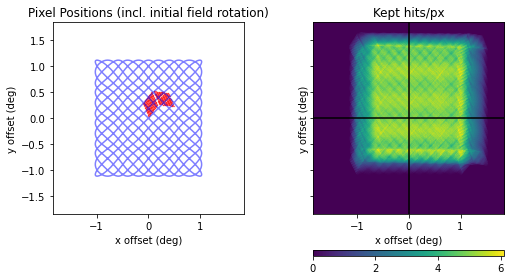

Generating histograms for kept hits...
...0/5867 completed...
total number of hits 6406764 == 6406764.0


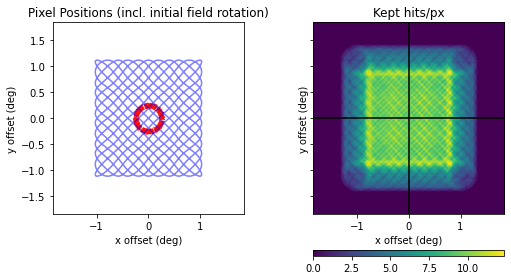

Generating histograms for kept hits...
...0/5867 completed...
total number of hits 11734 == 11734.0


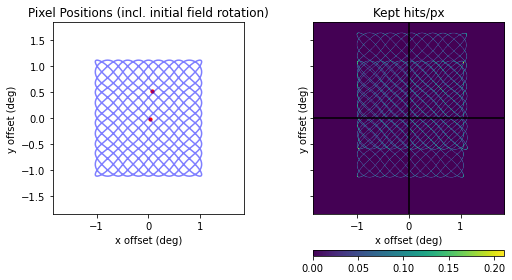

          x         y  pol  rhombus  wafer  pixel_num
0  0.339868  0.000000    0        0      0          0
1  0.346007  0.010633   45        0      0          1
Generating histograms for kept hits...
...0/5867 completed...
total number of hits 5867 == 5867.0


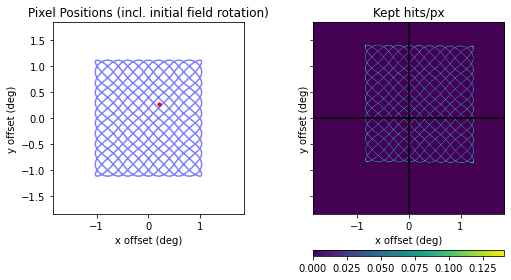

Generating histograms for kept hits...
...0/5867 completed...
total number of hits 6101680 == 6101680.0


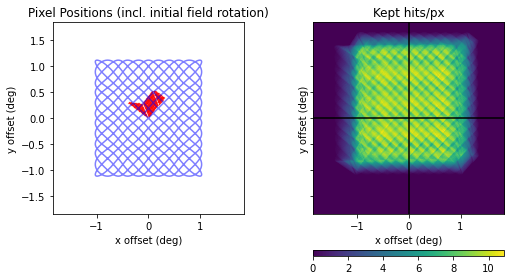

In [4]:
# let's make a Pong pattern centered at the boresight (at a lower sample interval since there's a lot)
pong = scanning.Pong(num_term=4, width=2, height=2, spacing='500 arcsec', velocity=1/2, sample_interval=1/40)
pong_T = scanning.TelescopePattern(pong, start_ra=40, start_dec=-60, start_hrang=0)

# polarizations, rhombuses, wafers
sim2 = scanning.Simulation(
    pong_T, scanning.Mod280, # use can pass a Module object instead (note that the TelescopePattern boresight will be used)
    pols_on=[0, 15], wafers_on=[0], 
    # rhombi_on=1
)
vis.hitmap(sim2) 

# detector elements falling inside a radius range
sim2 = scanning.Simulation(
    pong_T, scanning.Mod280,
    min_speed=0.1, # combine with min_speed/max_speed
    det_radius=[0.2*u.deg, 0.3*u.deg] 
)
vis.hitmap(sim2)

# a list of (x, y) positions to keep on the detector element closest to each position
sim2 = scanning.Simulation(
    pong_T, scanning.Mod280,
    det_list=[(0, 0), (1800, 1800)] # parameters requiring precise measurements are by default in arcseconds
)
vis.hitmap(sim2)

# a list of detector numbers "pixel_num" to keep on exact detector elements.
print(scanning.Mod280._data.head(2))
sim2 = scanning.Simulation(
    pong_T, scanning.Mod280,
    det_list=[0]
)
vis.hitmap(sim2)

# take the [(x_min, x_max), (y_min, y_max)] range of detector elements to keep
# note that the initial field rotation is applied to the left image, so that's why it's tilted
sim2 = scanning.Simulation(
    pong_T, scanning.Mod280,
    det_lim=[(0, 1800), (0, 1800)]
)
vis.hitmap(sim2)

---
You can save a copy or return of the 2D array hitmap. 

In [5]:
# get returned a 2D array and bin edges
sim1_hitmap, sim1_bin = sim1.sky_histogram(hits='kept', convolve=True, norm_time=False)
print('bins =', sim1_bin)
print('hitmap =', sim1_hitmap)

# pass a file into path_or_buf to get a csv file, with the columns and index representing bin edges
sim1.sky_histogram(hits='kept', convolve=False, norm_time=True, path_or_buf='daisy_hitmap.csv')
pd.read_csv('daisy_hitmap.csv', index_col=0, header=0).head()

bins = [-1.48611111 -1.48333333 -1.48055556 ...  1.47777778  1.48055556
  1.48333333] deg
hitmap = [[2.45511579e-13 2.66947626e-13 4.43266618e-14 ... 1.98580081e-13
  1.26547709e-13 6.58969275e-14]
 [2.43113081e-13 2.64493775e-13 4.25633001e-14 ... 1.98150843e-13
  1.25892430e-13 6.53804976e-14]
 [2.33294773e-13 2.54641305e-13 3.29023315e-14 ... 1.85662248e-13
  1.13480533e-13 5.31922956e-14]
 ...
 [2.27156023e-13 2.52603882e-13 2.42953397e-14 ... 1.83982849e-13
  1.14682023e-13 5.32486175e-14]
 [2.38909827e-13 2.63848636e-13 3.55236807e-14 ... 1.93754926e-13
  1.23572483e-13 6.22641090e-14]
 [2.37286744e-13 2.61549959e-13 3.32324566e-14 ... 1.91793941e-13
  1.21232224e-13 6.05178769e-14]]


,-1.4861111111111112,-1.4833333333333334,-1.4805555555555556,-1.4777777777777779,-1.475,-1.4722222222222223,-1.4694444444444446,-1.4666666666666668,-1.463888888888889,-1.4611111111111112,...,1.4583333333333335,1.4611111111111112,1.463888888888889,1.4666666666666668,1.4694444444444446,1.4722222222222223,1.475,1.4777777777777779,1.4805555555555556,1.4833333333333334
-1.486111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.483333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.480556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.477778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1.475000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Sky-Pixel Analysis

Specify pixel(s) in the x-y offset plane to focus on. You can get a histogram of which detector elements hit that region and how many times, as well as a histogram of the number of hits on that region per timestamp. 

In [6]:
sim3 = scanning.Simulation(
    daisy_T, module='Mod280', 
    pxan_lim=[(-30, 30), (-30, 30)], # a 6 by 6 pixel region on the center
    # pxan_list=[(0,0)]
    max_acc=0.25 # combine with other parameters like detector filters and sample filters
)

Generating histograms for kept hits...
...0/40035 completed...
total number of hits 207541440 == 207541440.0


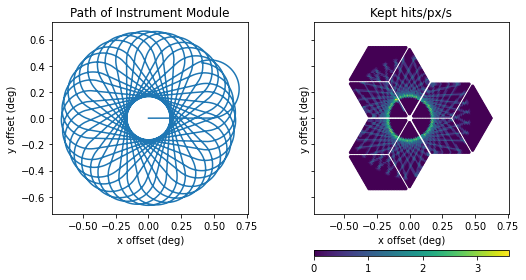

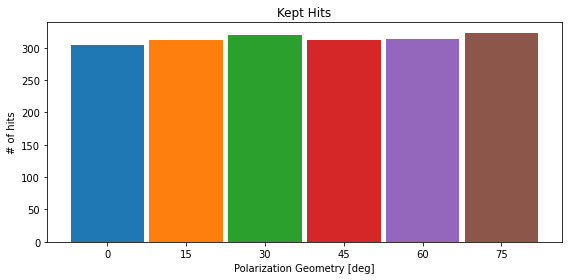

detector pixel # = [   0    1    2 ... 5181 5182 5183]
detector histogam = [0.55555556 0.61111111 0.22222222 ... 0.         0.         0.        ]


In [7]:
# get a hitmap of which detector elements hit that region and how many times
vis.pxan_detector(sim3, norm_pxan=True, norm_time=False) # norm_pxan: whether to average the hits by dividing the total hits by the number of pixels. 

# get a histogram of how many times each detector element, grouped by their initial pixel positions, hit that region
vis.pxan_polarization(sim3, norm_pxan=True, norm_time=False)

# return this detector histogram
# note that NaN values are used for detectors that have been filtered out
det_hist, det_pixel_num = sim3.det_histogram('kept', path=None, norm_pxan=True, norm_time=False)
print('detector pixel # =', det_pixel_num)
print('detector histogam =', det_hist)

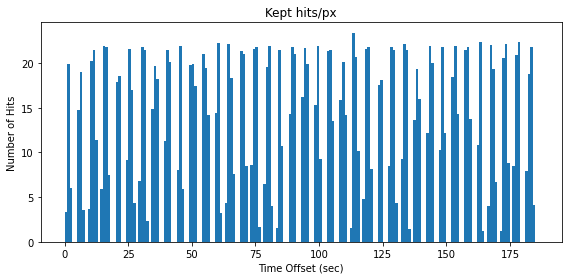

time offsets = [0.000000e+00 2.500000e-03 5.000000e-03 ... 1.859925e+02 1.859950e+02
 1.859975e+02]
time_hist = [ 0.  0.  0. ... nan nan nan]


In [8]:
# get a histogram of the number of hits on the region per timestamp
vis.pxan_time(sim3, bin=1*u.s, norm_pxan=True, norm_time=False)

# return this time histogram
# note that NaN values are used for samples that have been filtered out
time_hist, time_offsets = sim3.time_histogram('kept', path=None, norm_pxan=True, norm_time=False)
print('time offsets =', time_offsets)
print('time_hist =', time_hist)

## Polarization

Get a histogram of which polarization geometries have been captured. 

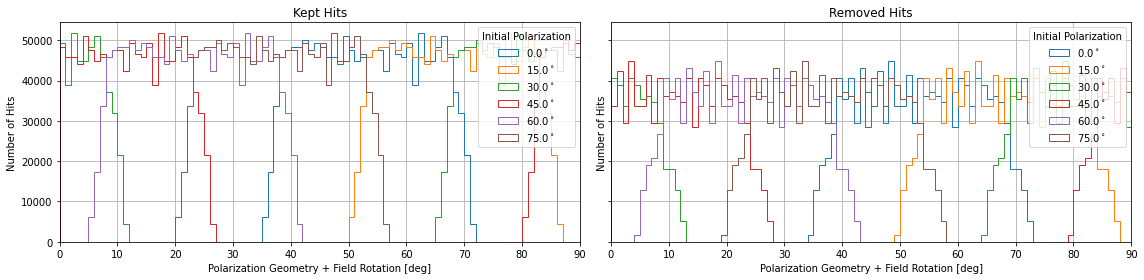

In [9]:
# let's use a longer scan
pong2 = scanning.Pong(num_term=4, width=2, height=2, spacing='400 arcsec', velocity=1/2, sample_interval=1, num_repeat=20)
telescope_pattern2 = scanning.TelescopePattern(pong2, instrument=prime_cam, start_ra=0, start_dec=0, start_hrang=0)
sim4 = scanning.Simulation(telescope_pattern2, 'Mod280', max_acc=0.25)
vis.polarization_histogram(sim4, stacked=False, removed_hits=True)

In [10]:
# return this
pol, initial_counts = sim4.pol_histogram('kept', path=None)

print('field rotation + detector geometry at each sample =')
print(pol)
print('number of detectors per geometry =', initial_counts)

field rotation + detector geometry at each sample =
           0.0        15.0       30.0       45.0       60.0       75.0
0     70.016096  85.016096  10.016096  25.016096  40.016096  55.016096
1     70.407660  85.407660  10.407660  25.407660  40.407660  55.407660
2     70.758986  85.758986  10.758986  25.758986  40.758986  55.758986
3     70.440341  85.440341  10.440341  25.440341  40.440341  55.440341
4     70.079776  85.079776  10.079776  25.079776  40.079776  55.079776
...         ...        ...        ...        ...        ...        ...
1804  37.640588  52.640588  67.640588  82.640588   7.640588  22.640588
1805  36.829856  51.829856  66.829856  81.829856   6.829856  21.829856
1806  35.970240  50.970240  65.970240  80.970240   5.970240  20.970240
1807  35.691714  50.691714  65.691714  80.691714   5.691714  20.691714
1808  36.501004  51.501004  66.501004  81.501004   6.501004  21.501004

[1809 rows x 6 columns]
number of detectors per geometry = [864 864 864 864 864 864]
